In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

/Users/uditg/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [2]:
energy_df = pd.read_csv('energy_cons.csv')
print(energy_df.shape)
energy_df.head()

(784, 19)


,Date,Data storage capacity,Data storage capacity added per day,Cumulative renewable energy purchases,Energy intensity lower bound,Energy intensity estimate,Energy intensity upper bound,Energy consumption rate lower bound,Energy consumption rate estimate,Energy consumption rate upper bound,Energy used to seal data lower bound,Energy used to seal data estimate,Energy used to seal data upper bound,Cumulative energy use lower bound,Cumulative energy use estimate,Cumulative energy use upper bound,Energy used to store data lower bound,Energy used to store data estimate,Energy used to store data upper bound
0,2020-08-24T00:00:00.000Z,498448,2053024,15734658.4700,1404.0981,10618.2456,21402.9825,651.8046,4929.1582,9935.6043,551.8939,3137.9856,5143.6463,15643.1789,118299.9113,238454.2728,0.4829,1.6056,4.3352
1,2020-08-25T00:00:00.000Z,9237744,13984256,16020743.1700,516.8322,3906.0165,7877.7548,4446.4727,33604.7076,67774.8419,3759.2477,21374.5158,35036.1550,122357.6233,924813.6787,1865048.9170,8.9495,29.7566,80.3434
2,2020-08-26T00:00:00.000Z,22553828,13212864,16306827.8700,200.7630,1514.9303,3059.6856,4217.0041,31820.9431,64268.3571,3551.8821,20195.4662,33103.5095,223564.8694,1688517.0540,3407488.0100,21.8501,72.6504,196.1574
3,2020-08-27T00:00:00.000Z,36361328,14277536,16592912.5700,134.9661,1017.1727,2056.6976,4570.5106,34445.6627,69648.2653,3838.0872,21822.7854,35770.9387,333256.2043,2515213.7590,5079044.7800,35.2269,117.1271,316.2454
4,2020-08-28T00:00:00.000Z,51427203,16174560,16878997.2700,108.3506,815.8238,1650.9771,5189.4841,39074.1396,79074.0694,4348.0452,24722.3297,40523.7426,457802.7809,3452994.0170,6976820.6400,49.8227,165.6573,447.2778


In [3]:
energy_df.loc[:, 'Date'] = energy_df.Date.apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d'))

In [4]:
#Check if any gap in data
energy_df.loc[:, 'Date'].diff().iloc[1:].value_counts()

1 days    783
Name: Date, dtype: int64

In [6]:
energy_df['Date Week'] = pd.PeriodIndex(energy_df.Date, freq='W')
energy_df['Date Month'] = pd.PeriodIndex(energy_df.Date, freq='M')
energy_df['Date Quarter'] = pd.PeriodIndex(energy_df.Date, freq='Q')

In [7]:
energy_df.set_index('Date', inplace=True)

### Note: For doing quarterly analysis, the dates from Oct-22 are dropped because they are very few in number

In [8]:
energy_df = energy_df.groupby('Date Quarter').filter(lambda x: len(x)>=30)

In [9]:
energy_df.loc[:, 'Renewable Energy as a fraction of Total Energy'] = \
    energy_df.loc[:, 'Cumulative renewable energy purchases']/energy_df.loc[:, 'Cumulative energy use estimate']

In [10]:
#Calculating Quarterly Average of all columns
energy_quarterly_mean_df = energy_df.groupby('Date Quarter').mean()

## Part 1: 
### a) Energy Performance

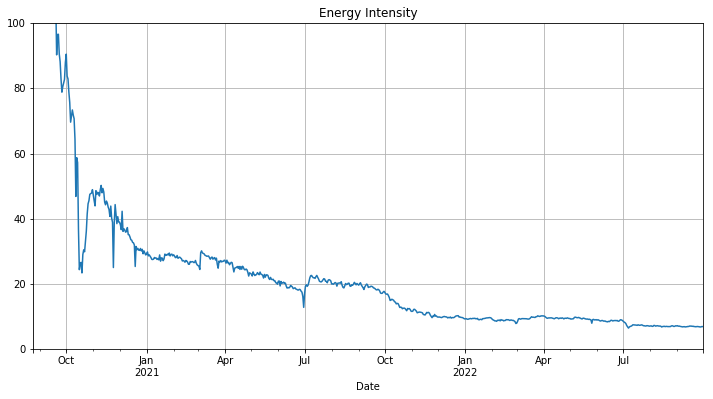

In [109]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_df.loc[:, ['Energy intensity estimate']].plot(ax=ax)
ax.set_title('Energy Intensity')
ax.set_ylim(0, 100)
ax.get_legend().remove()
ax.grid()

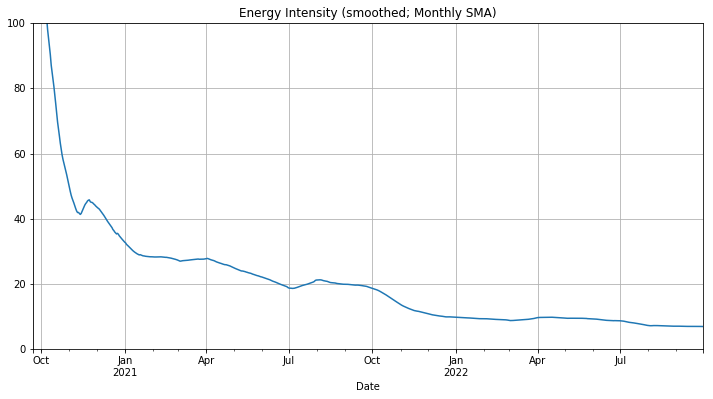

In [110]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_df.loc[:, ['Energy intensity estimate']].rolling(window=30).mean().dropna().plot(ax=ax)
ax.set_title('Energy Intensity (smoothed; Monthly SMA)')
ax.set_ylim(0, 100)
ax.get_legend().remove()
ax.grid()

1. Energy Performance definition: $$ \dfrac {K(constant)} {Energy Intensity} $$
2. Performance is defined to be inversely proportional to Energy Intensity as lower Intensity means better storage efficiency.

In [111]:
#Year on Year decrease
energy_intensity_sep_2020 = energy_df.loc[datetime(2020, 9, 30), 'Energy intensity estimate']
energy_intensity_sep_2021 = energy_df.loc[datetime(2021, 9, 30), 'Energy intensity estimate']
energy_intensity_sep_2022 = energy_df.loc[datetime(2022, 9, 30), 'Energy intensity estimate']

#

print("Increase in performance from Sep-2020 to Sep-2021: {:.1f}%".\
      format((energy_intensity_sep_2021**-1 - energy_intensity_sep_2020**-1)*100/(energy_intensity_sep_2020**-1)))

print("Increase in performance from Sep-2021 to Sep-2022: {:.1f}%".\
      format((energy_intensity_sep_2022**-1 - energy_intensity_sep_2021**-1)*100/(energy_intensity_sep_2021**-1)))

Increase in performance from Sep-2020 to Sep-2021: 395.4%
Increase in performance from Sep-2021 to Sep-2022: 155.9%


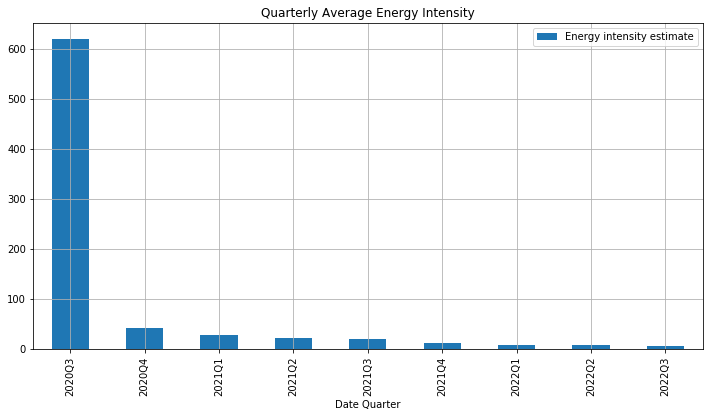

In [168]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_quarterly_mean_df.plot.bar(y='Energy intensity estimate', ax=ax)
ax.set_title('Quarterly Average Energy Intensity');
ax.grid()

In [158]:
energy_intensity_quarterly_df = energy_quarterly_mean_df.loc[:, ['Energy intensity estimate']]

#Considering a K(constant) value of 1000. (Just used for calculating % change, so the absolute value is not relevant)
energy_intensity_quarterly_df.loc[:, 'Performance proxy'] = 1000/energy_intensity_quarterly_df.loc[:, 'Energy intensity estimate']

#Calculating % change in performance Quarter over Quarter
energy_intensity_quarterly_df_pct_change = energy_intensity_quarterly_df.pct_change().dropna() * 100.0

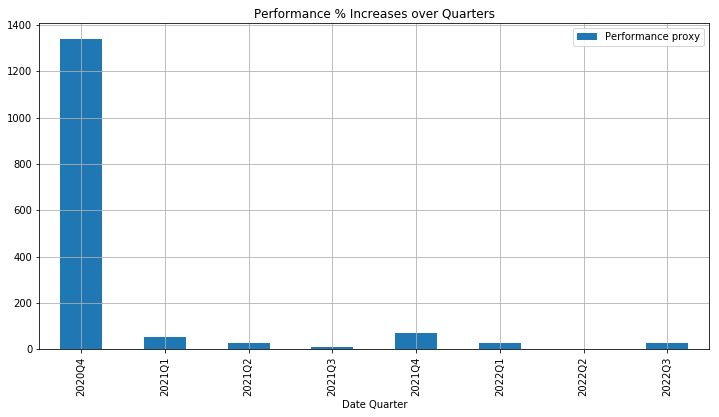

In [169]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_intensity_quarterly_df_pct_change.plot.bar(y='Performance proxy', ax=ax)
ax.set_title('Performance % Increases over Quarters')
ax.grid()

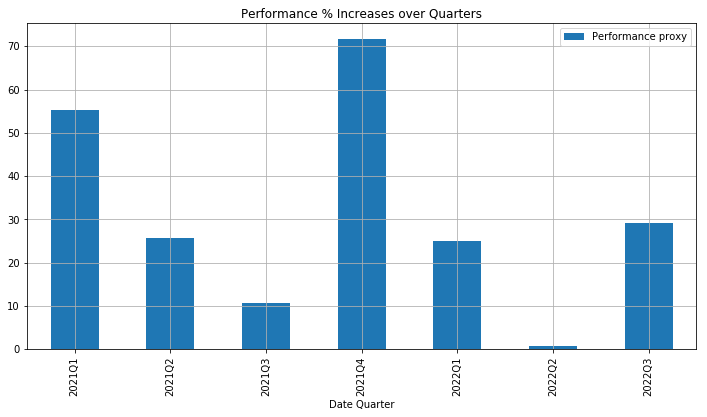

In [170]:
#First Quarter is an outlier. Removing it to visualize others better 
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_intensity_quarterly_df_pct_change.loc[lambda x: ~(x.index==pd.Period('2020Q4', 'Q-DEC'))]\
    .plot.bar(y='Performance proxy', ax=ax)
ax.set_title('Performance % Increases over Quarters')
ax.grid()

## Part 1
### b) Storage Capacity Evolution

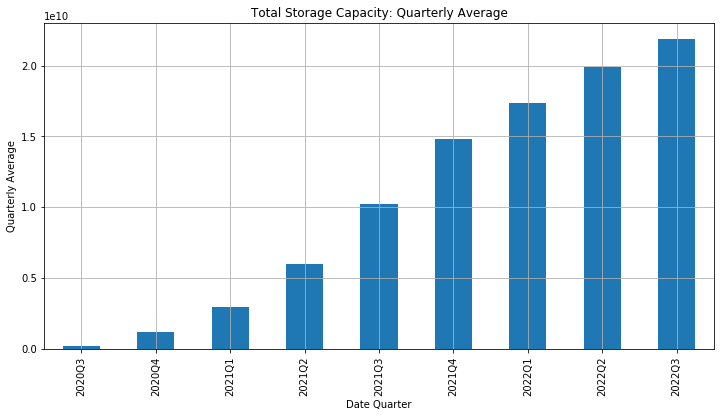

In [173]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_quarterly_mean_df.plot.bar(y='Data storage capacity', ax=ax)
ax.set_title('Total Storage Capacity: Quarterly Average');
ax.get_legend().remove()
ax.set_ylabel('Quarterly Average')
ax.grid()

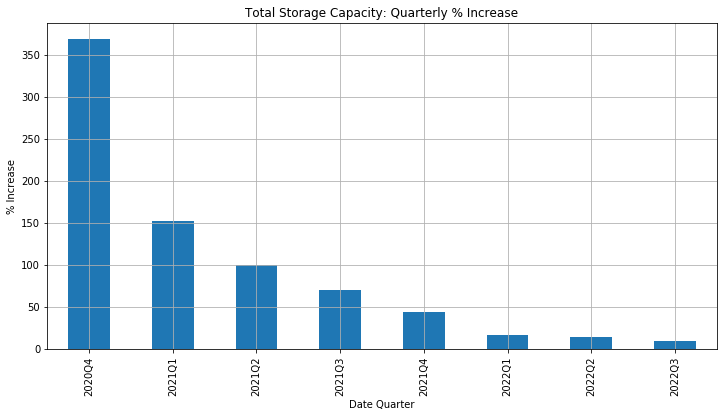

In [175]:
energy_total_storage_pct_change = energy_quarterly_mean_df.loc[:, ['Data storage capacity']].pct_change().dropna() * 100.0

fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_total_storage_pct_change.plot.bar(y='Data storage capacity', ax=ax)
ax.set_title('Total Storage Capacity: Quarterly % Increase');
ax.set_ylabel('% Increase')
ax.get_legend().remove()
ax.grid()

Note: Storage Capacity seems to be saturating

## Part 1
### c) Share of Renewable Energy

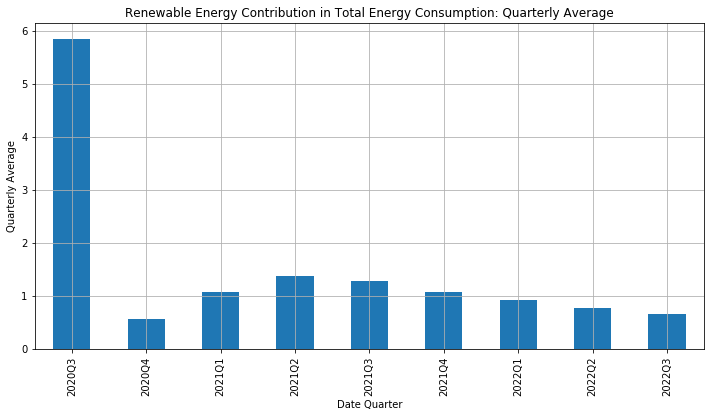

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
energy_quarterly_mean_df.plot.bar(y='Renewable Energy as a fraction of Total Energy', ax=ax)
ax.set_title('Renewable Energy Contribution in Total Energy Consumption: Quarterly Average');
ax.get_legend().remove()
ax.set_ylabel('Quarterly Average')
ax.grid()

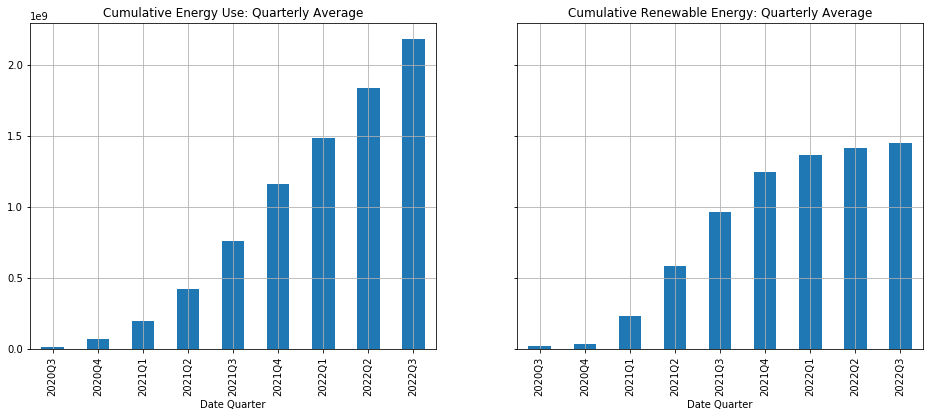

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,6), sharey=True)
energy_quarterly_mean_df.plot.bar(y='Cumulative energy use estimate', ax=ax[0])
energy_quarterly_mean_df.plot.bar(y='Cumulative renewable energy purchases', ax=ax[1])
ax[0].set_title('Cumulative Energy Use: Quarterly Average');
ax[1].set_title('Cumulative Renewable Energy: Quarterly Average');
for x in ax:
    x.get_legend().remove()
    x.grid()

## Part 2

## Read FIL pricing data

In [11]:
price_df = pd.read_csv('price.csv')
print(price_df.shape)
price_df.tail()

(1801, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
1796,2022-11-13,4.2682,4.4299,4.2222,4.2940,4.2940,119578514
1797,2022-11-14,4.2944,4.3900,4.1065,4.3166,4.3166,161268566
1798,2022-11-15,4.3168,4.4911,4.2921,4.3891,4.3891,114251131
1799,2022-11-16,4.3888,4.5340,4.2746,4.3379,4.3379,147278408
1800,2022-11-17,4.3348,4.3838,4.2626,4.2859,4.2859,130081440


In [12]:
price_df.loc[:, 'Date'] = price_df.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [13]:
consolidated_df = pd.merge(energy_df, price_df.loc[:, ['Date', 'Adj Close']], left_index=True, right_on='Date')
consolidated_df = consolidated_df.rename(columns={'Adj Close': 'FIL price'})
consolidated_df.set_index('Date', inplace=True)
consolidated_df.head()

,Data storage capacity,Data storage capacity added per day,Cumulative renewable energy purchases,Energy intensity lower bound,Energy intensity estimate,Energy intensity upper bound,Energy consumption rate lower bound,Energy consumption rate estimate,Energy consumption rate upper bound,Energy used to seal data lower bound,Energy used to seal data estimate,Energy used to seal data upper bound,Cumulative energy use lower bound,Cumulative energy use estimate,Cumulative energy use upper bound,Energy used to store data lower bound,Energy used to store data estimate,Energy used to store data upper bound,Date Week,Date Month,Date Quarter,Renewable Energy as a fraction of Total Energy,FIL price
Date,,,,,,,,,,,,,,,,,,,,,,,
2020-08-24,498448,2053024,15734658.4700,1404.0981,10618.2456,21402.9825,651.8046,4929.1582,9935.6043,551.8939,3137.9856,5143.6463,15643.1789,118299.9113,238454.2728,0.4829,1.6056,4.3352,2020-08-24/2020-08-30,2020-08,2020Q3,133.0065,22.0202
2020-08-25,9237744,13984256,16020743.1700,516.8322,3906.0165,7877.7548,4446.4727,33604.7076,67774.8419,3759.2477,21374.5158,35036.1550,122357.6233,924813.6787,1865048.9170,8.9495,29.7566,80.3434,2020-08-24/2020-08-30,2020-08,2020Q3,17.3232,22.1935
2020-08-26,22553828,13212864,16306827.8700,200.7630,1514.9303,3059.6856,4217.0041,31820.9431,64268.3571,3551.8821,20195.4662,33103.5095,223564.8694,1688517.0540,3407488.0100,21.8501,72.6504,196.1574,2020-08-24/2020-08-30,2020-08,2020Q3,9.6575,21.4626
2020-08-27,36361328,14277536,16592912.5700,134.9661,1017.1727,2056.6976,4570.5106,34445.6627,69648.2653,3838.0872,21822.7854,35770.9387,333256.2043,2515213.7590,5079044.7800,35.2269,117.1271,316.2454,2020-08-24/2020-08-30,2020-08,2020Q3,6.5970,22.1594
2020-08-28,51427203,16174560,16878997.2700,108.3506,815.8238,1650.9771,5189.4841,39074.1396,79074.0694,4348.0452,24722.3297,40523.7426,457802.7809,3452994.0170,6976820.6400,49.8227,165.6573,447.2778,2020-08-24/2020-08-30,2020-08,2020Q3,4.8882,24.2735


## Part 2
### a) Correlation between Price and Energy used for sealing data

In [14]:
consolidated_df.loc[:, ['Energy used to seal data lower bound', 
                        'Energy used to seal data estimate', 
                        'Energy used to seal data upper bound',
                       'FIL price']].corr()

,Energy used to seal data lower bound,Energy used to seal data estimate,Energy used to seal data upper bound,FIL price
Energy used to seal data lower bound,1.0000,1.0000,1.0000,0.5738
Energy used to seal data estimate,1.0000,1.0000,1.0000,0.5738
Energy used to seal data upper bound,1.0000,1.0000,1.0000,0.5738
FIL price,0.5738,0.5738,0.5738,1.0000


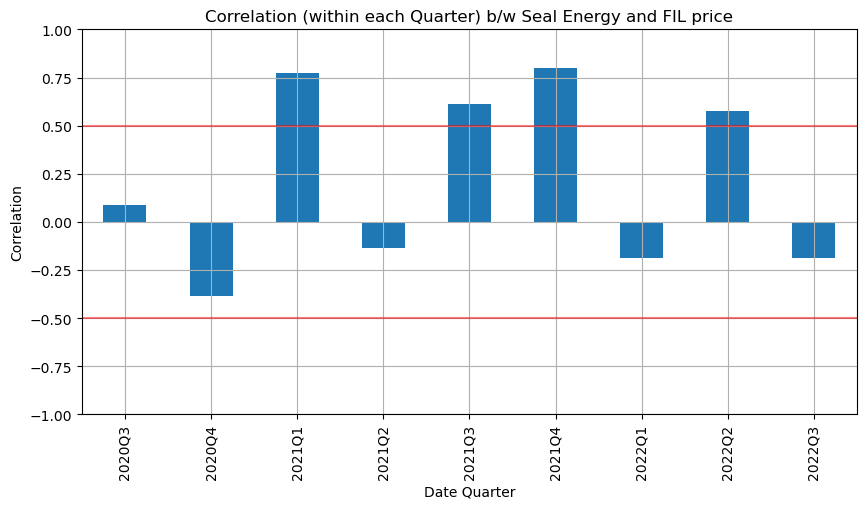

In [28]:
#Computing correlation within each Quarter.

comparison_column = 'Energy used to seal data estimate'
fig, ax = plt.subplots(1,1, figsize=(10, 5))
consolidated_df.groupby('Date Quarter').apply(lambda df: \
                                            df.loc[:, [comparison_column, 'FIL price']]\
                                            .corr().values[0,1]).plot.bar(ax=ax)
ax.grid()
ax.set_ylim(-1, 1)
ax.axhline(0.5, c='r', alpha=0.5)
ax.axhline(-0.5, c='r', alpha=0.5)
ax.set_ylabel('Correlation')
ax.set_title('Correlation (within each Quarter) b/w Seal Energy and FIL price');

In [175]:
# 4/10 Quarters depict significant correlation b/w Price and Seal Energy

In [24]:
scaler = StandardScaler()
consolidated_df_scaled = scaler.fit_transform(consolidated_df.loc[:, ['Energy used to seal data estimate',
                                                                                    'FIL price']])
consolidated_df_scaled = pd.DataFrame(consolidated_df_scaled,
                                                    index = consolidated_df.index,
                                                    columns = ['Energy used to seal data estimate',
                                                                                    'FIL price'])
consolidated_df_scaled = pd.merge(consolidated_df_scaled, consolidated_df.loc[:, ['Date Quarter']],
                                 left_index=True, right_index=True, how='inner')

In [25]:
#Computing Correlation b/w Average Seal Energy and Average FIL price, across Quarters. 

consolidated_quarterly_mean_df = consolidated_df_scaled.groupby('Date Quarter')\
                                    .agg({'Energy used to seal data estimate': 'mean',
                                         'FIL price': 'mean'})

#Correlation is 83% which is significant
consolidated_quarterly_mean_df.corr()

,Energy used to seal data estimate,FIL price
Energy used to seal data estimate,1.0000,0.6615
FIL price,0.6615,1.0000


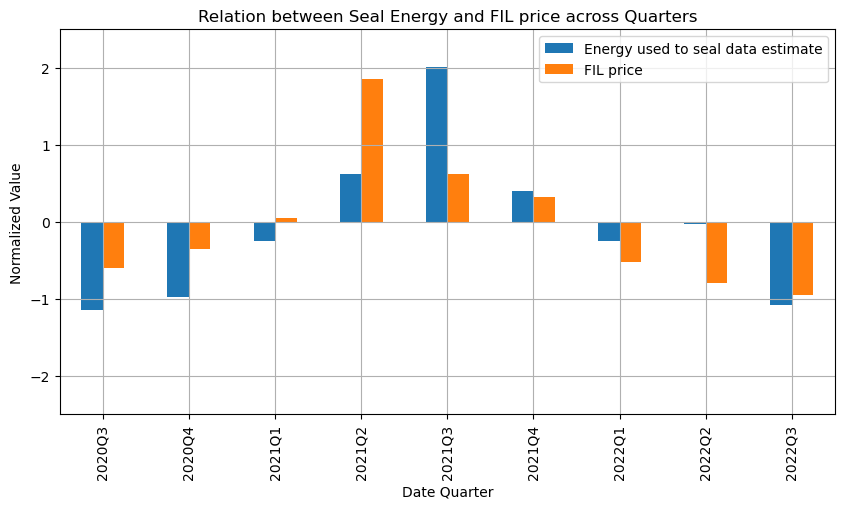

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
consolidated_quarterly_mean_df.plot.bar(ax=ax)
ax.grid()
ax.set_ylabel('Normalized Value')
ax.set_ylim(-2.5, 2.5)
ax.set_title('Relation between Seal Energy and FIL price across Quarters');

In [ ]:
#9 same signs & 1 different signs

## Part 2
### b) Correlation between Storage added per day and FIL price

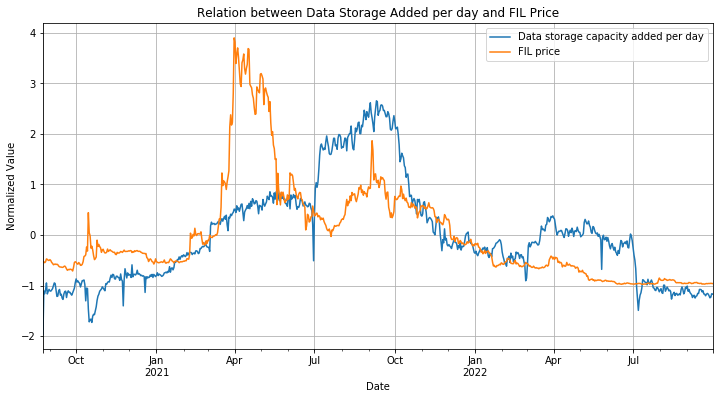

In [26]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
scaler = StandardScaler()
consolidated_df_scaled = scaler.fit_transform(consolidated_df.loc[:, ['Data storage capacity added per day',
                                                                 'FIL price']])
consolidated_df_scaled = pd.DataFrame(consolidated_df_scaled,
                                                    index = consolidated_df.index,
                                                    columns = ['Data storage capacity added per day',
                                                              'FIL price'])
consolidated_df_scaled.plot(ax=ax)
ax.grid()
ax.set_ylabel('Normalized Value')
ax.set_title('Relation between Data Storage Added per day and FIL Price');

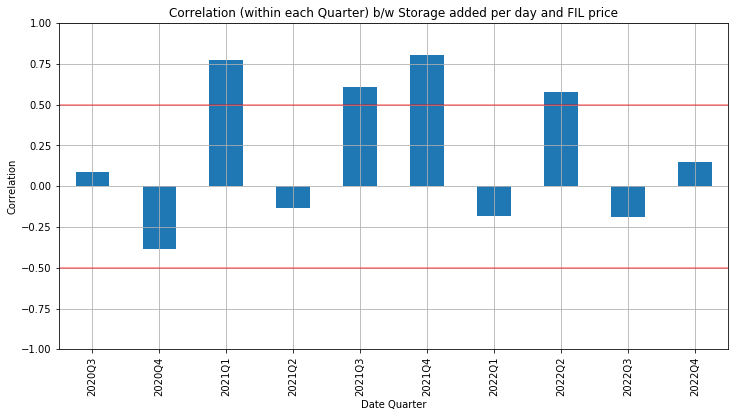

In [184]:
#Computing correlation within each Quarter.

comparison_column = 'Data storage capacity added per day'
fig, ax = plt.subplots(1,1, figsize=(12, 6))
consolidated_df.groupby('Date Quarter').apply(lambda df: \
                                            df.loc[:, [comparison_column, 'FIL price']]\
                                            .corr().values[0,1]).plot.bar(ax=ax)
ax.grid()
ax.set_ylim(-1, 1)
ax.axhline(0.5, c='r', alpha=0.5)
ax.axhline(-0.5, c='r', alpha=0.5)
ax.set_ylabel('Correlation')
ax.set_title('Correlation (within each Quarter) b/w Storage added per day and FIL price');

In [130]:
#This is exactly same as part 'a' because 'Energy used to seal data' is obtained by 
#multiplying a constant value to 'Data storage increase over time' as mentioned in the docs.
#Therefore the correlation with FIL price will be same for both.

## Part 2
### c) Correlation between Energy consumption rate and FIL price

In [196]:
consolidated_df.loc[:, ['Energy consumption rate estimate',
                       'FIL price']].corr()

,Energy consumption rate estimate,FIL price
Energy consumption rate estimate,1.0000,0.0837
FIL price,0.0837,1.0000


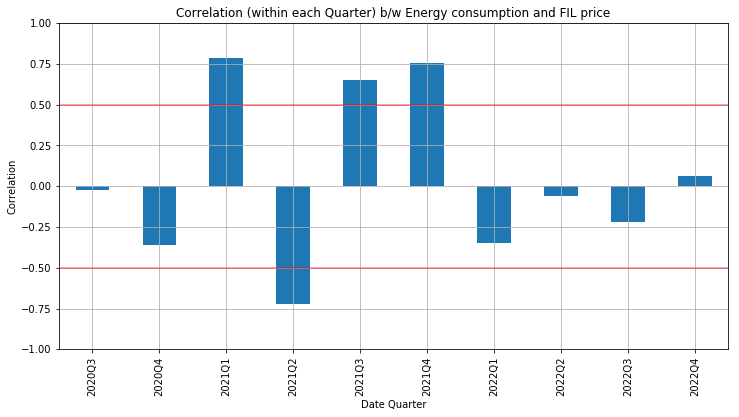

In [197]:
#Computing correlation within each Quarter.

comparison_column = 'Energy consumption rate estimate'
fig, ax = plt.subplots(1,1, figsize=(12, 6))
consolidated_df.groupby('Date Quarter').apply(lambda df: \
                                            df.loc[:, [comparison_column, 'FIL price']]\
                                            .corr().values[0,1]).plot.bar(ax=ax)
ax.grid()
ax.set_ylim(-1, 1)
ax.axhline(0.5, c='r', alpha=0.5)
ax.axhline(-0.5, c='r', alpha=0.5)
ax.set_ylabel('Correlation')
ax.set_title('Correlation (within each Quarter) b/w Energy consumption and FIL price');

In [32]:
scaler = StandardScaler()
consolidated_df_scaled = scaler.fit_transform(consolidated_df.loc[:, ['Energy consumption rate estimate',
                                                                     'FIL price']])
consolidated_df_scaled = pd.DataFrame(consolidated_df_scaled,
                                        index = consolidated_df.index,
                                        columns = ['Energy consumption rate estimate',
                                                                 'FIL price'])
consolidated_df_scaled = pd.merge(consolidated_df_scaled, consolidated_df.loc[:, ['Date Quarter']],
                                 left_index=True, right_index=True, how='inner')

# consolidated_quarterly_mean_df_scaled.plot.bar(ax=ax)
# ax.grid()
# ax.set_ylabel('Normalized Value')
# ax.set_ylim(-2.5, 2.5)
# ax.set_title('Relation between Energy consumption and FIL price across Quarters');

In [33]:
consolidated_quarterly_mean_df = consolidated_df_scaled.groupby('Date Quarter')\
                                    .agg({'Energy consumption rate estimate': 'mean',
                                         'FIL price': 'mean'})

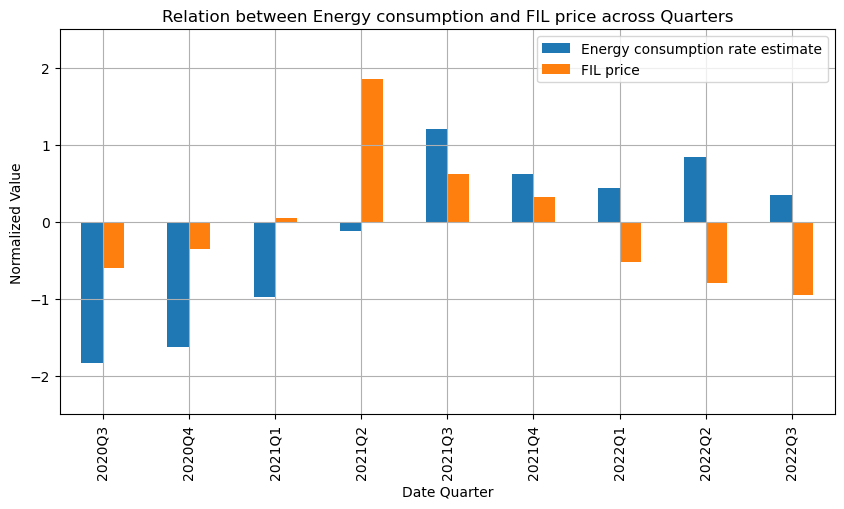

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

consolidated_quarterly_mean_df.plot.bar(ax=ax)
ax.grid()
ax.set_ylabel('Normalized Value')
ax.set_ylim(-2.5, 2.5)
ax.set_title('Relation between Energy consumption and FIL price across Quarters');

In [ ]:
# 5 same signs, 5 differnt signs